# SETUP

In [1]:
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex5 import *
from pathlib import Path
from learntools.time_series.style import *  # plot style settings

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor


comp_dir = Path('../input/store-sales-time-series-forecasting')
data_dir = Path("../input/ts-course-data")

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)
family_sales.head(4)

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124146   10.629630  1711.907349  1204.203735  404.300049   
2017-01-04   594.160645   11.185185  1508.036987  1107.796265  309.397675   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  

[4 rows x 66 columns]

-------------------------------------------------------------------------------


# 1) Creating the BoostedHybrid Class
We'll create a class BoostedHybrid that allows us to fit a hybrid model in a scikit-learn style interface.

In [2]:
# Define the BoostedHybrid class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method



## i. Define the 'fit' method

The fit method trains the first model on the data, computes the residuals, and then trains the second model on these residuals.

In [3]:
def fit(self, X_1, X_2, y):
    # Train model_1
    self.model_1.fit(X_1, y)

    # Make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # Compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # Train model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    #self.y_fit = y_fit
    #self.y_resid = y_resid

# Add method to class
BoostedHybrid.fit = fit



## ii. Define predict method for boosted hybrid

The 'predict' method uses both models to make predictions. It first gets predictions from the first model and then adds the residuals predicted by the second model.

In [4]:
def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()

# Add method to class
BoostedHybrid.predict = predict

# 2) Data Preparation (feature engineering)
Next, we prepare our data for training the hybrid model.

In [5]:
def create_features(y, family_sales):
    # Target series

    # X_1: Features for Linear Regression (capturing trend)
    dp = DeterministicProcess(index=y.index, order=1)
    X_1 = dp.in_sample()


    # X_2: Features for XGBoost (capturing residual)
    X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature
    # Label encoding for 'family'
    le = LabelEncoder()
    X_2 = X_2.reset_index('family')
    X_2['family'] = le.fit_transform(X_2['family'])

    # Label encoding for seasonality
    X_2["day"] = X_2.index.day  # values are day of the month
    X_2["day_of_week"] = X_2.index.dayofweek  # day of the week
    X_2["month"] = X_2.index.month  # month of the year 

    return X_1, X_2

# Target series
y = family_sales.loc[:, 'sales']

# Create features
X_1, X_2 = create_features(y, family_sales)

display(X_1)
display(X_2)

,trend
date,
2017-01-01,1.0
2017-01-02,2.0
2017-01-03,3.0
2017-01-04,4.0
2017-01-05,5.0
...,...
2017-08-11,223.0
2017-08-12,224.0
2017-08-13,225.0


,family,onpromotion,day,day_of_week,month
date,,,,,
2017-01-01,0,0.000000,1,6,1
2017-01-01,1,0.000000,1,6,1
2017-01-01,2,0.000000,1,6,1
2017-01-01,3,0.703704,1,6,1
2017-01-01,4,0.000000,1,6,1
...,...,...,...,...,...
2017-08-15,28,0.111111,15,1,8
2017-08-15,29,0.166667,15,1,8
2017-08-15,30,58.685185,15,1,8


# 3) Train the Hybrid Model

We initialize our hybrid model with 'LinearRegression' and 'XGBRegressor' and fit it to our training data.

In [6]:
# Create model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)
model.fit(X_1, X_2, y)

# Make predictions
y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)
y_pred.head(3)

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.00000,0.000000,0.000000,102.664680,0.000000,154.875167,0.000000,78.361320,0.000000,0.000000,...,0.000000,176.295135,32.558789,0.000000,0.000000,115.094119,0.000000,164.932478,0.000000,0.000000
2017-01-02,0.00000,6.516237,29.533806,6212.134078,7.767436,767.807897,40.528475,2162.746693,1581.999329,550.999946,...,16.352404,415.442823,700.147437,57.593428,30.186453,528.010983,185.903033,3357.851898,5.936456,53.070656
2017-01-03,21.25443,10.935052,16.719029,4505.264791,8.693990,655.101360,20.021285,1718.808122,1185.614470,375.119122,...,10.917314,369.585667,472.968523,30.665556,20.111647,429.051651,133.986312,3379.489214,2.672748,27.965932


### Visualizing Predictions

We can visualize the predictions made by our hybrid model.

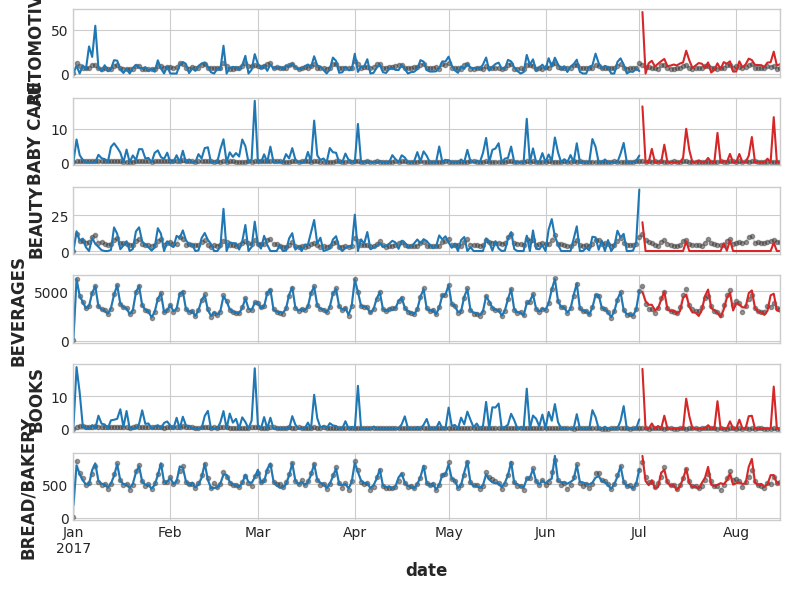

In [7]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Train the model and make predictions
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

# Plot results
families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(8, 6), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)


### Evaluating Model Performance

Evaluate our model's performance using metrics such as Root Mean Squared Error (RMSE).

In [8]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE for training and validation sets
rmse_train = mean_squared_error(y_train, y_fit, squared=False)
rmse_valid = mean_squared_error(y_valid, y_pred, squared=False)

print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valid}")

Train RMSE: 17.39587317515901
Validation RMSE: 64.71618985555173


# 4) Experimenting with Other Models

In time series forecasting, combining different machine learning models can significantly improve prediction accuracy. This section explores experimenting with different combinations of models for `model_1` and `model_2`. Each model type has its strengths and weaknesses, which can be leveraged when combined effectively.

### Choosing Models for `model_1`

`model_1` is typically used to capture the **trend component** of the time series. Models that are well-suited for this task include:

- **Linear Regression**: Captures linear trends.
- **Ridge Regression**: Similar to linear regression but includes a regularization term.
- **Lasso Regression**: Similar to Ridge but can shrink some coefficients to zero, effectively performing feature selection.
- **ElasticNet**: Combines Lasso and Ridge regression by adding both $L1$ and $L2$ penalties.

**Feature Engineering for `model_1`**:
- **Deterministic Trends**: Including polynomial terms or Fourier terms for capturing non-linear trends and seasonal effects.
- **Time Index**: Using the time index itself as a feature to model time progression.
- **Log Transformation**: Applying log transformation for series with exponential growth.
- **Fourier Terms**: Adding sine and cosine functions to model periodic patterns, useful for capturing seasonality.

### Choosing Models for `model_2`

`model_2` is used to capture the **residuals** left after fitting `model_1`. These models typically excel at capturing non-linear patterns and interactions. Suitable models for `model_2` include:

- **XGBoost**: A powerful gradient boosting algorithm that handles non-linear interactions well.
- **Random Forest**: An ensemble of decision trees that can capture complex patterns.
- **Extra Trees Regressor**: Similar to Random Forest but with more randomness in tree creation.
- **K-Nearest Neighbors (KNN)**: Captures local patterns based on neighboring data points.
- **MLP Regressor (Neural Network)**: Captures non-linear interactions using neural network layers.

**Feature Engineering for `model_2`**:
- **Lag Features**: Including past values of the series to capture temporal dependencies.
- **Rolling Statistics**: Adding rolling mean, rolling standard deviation, rolling min/max, etc., to capture the moving window statistics.
- **Seasonal Indicators**: Encoding seasonality using sine and cosine transformations for different periodicities (e.g., daily, weekly, monthly).
- **Categorical Encoding**: Using label encoding for categorical features like day of the week, month, or special holidays.
- **Interaction Terms**: Creating interaction terms between different features to capture combined effects.

This example allows you to experiment with different combinations of models and visualize the results. Adjust `model_1` and `model_2` to see how different combinations affect the forecast accuracy. The printed RMSE values help evaluate and compare the performance of each hybrid model.

In [9]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

models = [
    # Linear Regression Combinations
    (LinearRegression(), KNeighborsRegressor()),
    (LinearRegression(), RandomForestRegressor()),
    (LinearRegression(), ExtraTreesRegressor()),
    (LinearRegression(), MLPRegressor()),
    (LinearRegression(), XGBRegressor()),
    (LinearRegression(), GradientBoostingRegressor()),

    # Ridge Regression Combinations
    (Ridge(), KNeighborsRegressor()),
    (Ridge(), RandomForestRegressor()),
    (Ridge(), ExtraTreesRegressor()),
    (Ridge(), MLPRegressor()),
    (Ridge(), XGBRegressor()),
    (Ridge(), GradientBoostingRegressor()),

    # ElasticNet Combinations
    (ElasticNet(), KNeighborsRegressor()),
    (ElasticNet(), RandomForestRegressor()),
    (ElasticNet(), ExtraTreesRegressor()),
    (ElasticNet(), MLPRegressor()),
    (ElasticNet(), XGBRegressor()),
    (ElasticNet(), GradientBoostingRegressor()),

    # Lasso Regression Combinations
    (Lasso(), KNeighborsRegressor()),
    (Lasso(), RandomForestRegressor()),
    (Lasso(), ExtraTreesRegressor()),
    (Lasso(), MLPRegressor()),
    (Lasso(), XGBRegressor()),
    (Lasso(), GradientBoostingRegressor())
]


# Experiment with different model combinations
for model_1, model_2 in models:
    # Create and train the model
    model = BoostedHybrid(model_1=model_1, model_2=model_2)
    model.fit(X1_train, X2_train, y_train)
    
    # Make predictions
    y_fit_new = model.predict(X1_train, X2_train).clip(0.0)
    y_pred_new = model.predict(X1_valid, X2_valid).clip(0.0)
    
    # Calculate RMSE for training and validation sets
    rmse_train_new = mean_squared_error(y_train, y_fit_new, squared=False)
    rmse_valid_new = mean_squared_error(y_valid, y_pred_new, squared=False)
    
    print(f"Model 1: {model_1.__class__.__name__}, Model 2: {model_2.__class__.__name__}")
    print(f"Train RMSE: {rmse_train_new}")
    print(f"Validation RMSE: {rmse_valid_new}")
    print("-" * 40)

Model 1: LinearRegression, Model 2: KNeighborsRegressor
Train RMSE: 84.19508425385048
Validation RMSE: 94.90180647160818
----------------------------------------
Model 1: LinearRegression, Model 2: RandomForestRegressor
Train RMSE: 23.256355373652575
Validation RMSE: 61.127684317292285
----------------------------------------
Model 1: LinearRegression, Model 2: ExtraTreesRegressor
Train RMSE: 1.6647781216532978e-13
Validation RMSE: 63.90693277886766
----------------------------------------
Model 1: LinearRegression, Model 2: MLPRegressor
Train RMSE: 109.90869857525647
Validation RMSE: 95.24542041695591
----------------------------------------
Model 1: LinearRegression, Model 2: XGBRegressor
Train RMSE: 17.39587317515901
Validation RMSE: 64.71618985555173
----------------------------------------
Model 1: LinearRegression, Model 2: GradientBoostingRegressor
Train RMSE: 78.05608331213936
Validation RMSE: 75.62067666233159
----------------------------------------
Model 1: Ridge, Model 2: K

The model combination of **Ridge** for Model 1 and **RandomForestRegressor** for Model 2 had the best validation RMSE, achieving a score of 59.06

New Model Train RMSE: 23.03338221734858
New Model Validation RMSE: 60.1315168845009


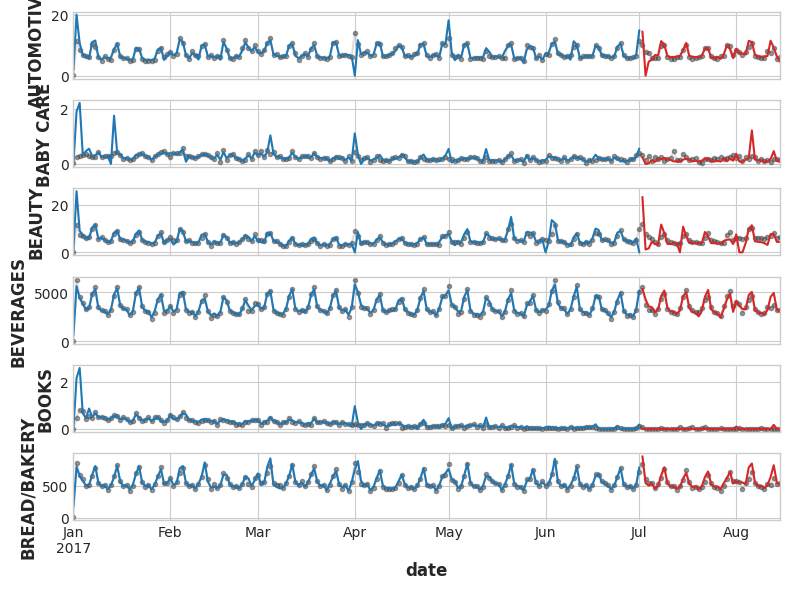

In [12]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Create model with different algorithms
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=RandomForestRegressor(),
)

# Train and evaluate the model
model.fit(X1_train, X2_train, y_train)
y_fit_new = model.predict(X1_train, X2_train).clip(0.0)
y_pred_new = model.predict(X1_valid, X2_valid).clip(0.0)

# Calculate RMSE for training and validation sets with new model
rmse_train_new = mean_squared_error(y_train, y_fit_new, squared=False)
rmse_valid_new = mean_squared_error(y_valid, y_pred_new, squared=False)

print(f"New Model Train RMSE: {rmse_train_new}")
print(f"New Model Validation RMSE: {rmse_valid_new}")

# Plot results for new model
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(8, 6), **plot_params, alpha=0.5,
)
_ = y_fit_new.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred_new.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)
